<h1 style="text-align: center;" markdown="1">Encoder Layer</h1>


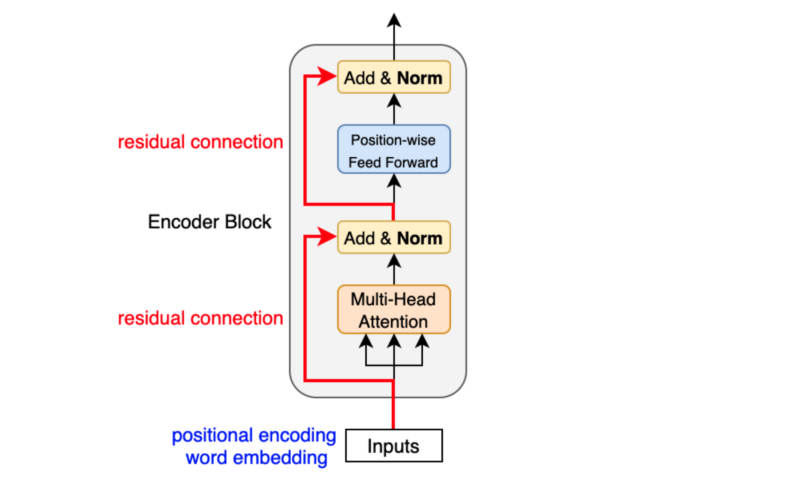

In [2]:
import torch
import math
from torch import nn
import torch.nn.functional as F

## Scaled-dot Product
(*To calculate self-attention*)

In [3]:
def scaled_dot_product(q, k, v, mask =None): # To calculate self-attention
    # q,k,v = 30 X 8 X 200 X64
    d_k =q.size()[-1] # 64
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # 30 X 8 X 200 X 200
    print(f"scaled.size(): {scaled.size()}")
    if mask is not None:
        print(f" -- Adding Mask of shape {mask.size()} --")
        scaled += mask # 30 X 8 X 200 X 200
    attention = F.softmax(scaled, dim= -1) # 30 X 8 X 200 X 200
    values = torch.matmul(attention, v) # 30 X 8 X 200 X 64 // 64 is here the embedding of the value tensor
    return values, attention # this new value vector is much more context aware now

## Multi-head Attention

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model # 512
        self.num_heads =num_heads # 8
        self.head_dim = d_model//num_heads # 64
        self.qkv_layer = nn.Linear(d_model, 3*d_model) # 512 X 1536
        self.linear_layer = nn.Linear(d_model, d_model) # 512 X 512
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, d_model = x.size() # 30 X 200 X 512
        print(f"x.size(): {x.size()}")

        qkv = self.qkv_layer(x) # 30 X 200 X 1536
        print(f"qkv.size(): {qkv.size()}")

        qkv = qkv.reshape( batch_size, sequence_length, self.num_heads, 3*self.head_dim) # 30 X 200 X 8 X 192
        print(f"qkv.size() after reshaping: {qkv.size()}")

        qkv = qkv.permute( 0, 2, 1, 3) # 30 X 8 X 200 X 192
        print(f"qkv.size() after permuting: {qkv.size()}")

        q, k, v = qkv.chunk(3, dim=-1) # each are 30 X 8 X 200 X 64 // we will divide each chunk for each head
        print(f" -> q size: {q.size()}\n -> k size: {k.size()}\n -> v size: {v.size()} ")

        values, attention = scaled_dot_product(q, k, v, mask) # attention = 30 X 8 X 200 X 200 || Values = 30 X 8 X 200 X 64
        print(f"After Scaling\n -> values.size(): {values.size()}\n -> attention.size() : {attention.size()}")

        values = values.reshape( batch_size, sequence_length, self.num_heads*self.head_dim) # 30 X 200 X 512(8*64)
        print(f"values.size() after merging all heads: {values.size()}")

        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        
        return out

## Layer Normalization
( *ADD & NORM* )

In [5]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps = 1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape # [512] // along which dimension we want to perform layer normalization
        self.eps=eps # small value to prevent denm. from getting zero
        self.gamma=nn.Parameter(torch.ones(parameters_shape)) # [512] // S.D values
        self.beta =nn.Parameter(torch.ones(parameters_shape)) # [512] // Mean values
    
    def forward(self,inputs): # 30 X 200 X 512
        dims = [-(i+1) for i in range(len(self.parameters_shape))] #[-1] // the last dimension along which we want to perform layer normalization.
        
        mean = inputs.mean(dim=dims, keepdim=True) # 30 X 200 X 1
        print(f"Mean size: {mean.size()}")
        
        var = ((inputs-mean)**2).mean(dim=dims, keepdim=True) # 30 X 200 X 1
        std=(var+self.eps).sqrt() # 30 X 200 X 1
        print(f"S.D size: {std.size()}")
        
        y=(inputs-mean)/std # 30 X 200 X 512
        print(f"y size: {y.size()}")
        
        out=self.gamma*y + self.beta # we have 512 gammas & betas for 1 for each sequence in each batch 
        print(f" -> self.gamma: {self.gamma.size()}\n -> self.beta: {self.beta.size()}") # Both are learnable parameters
        print(f"out size: {out.size()}")
        
        return out

After layer Norm we are going to get much more stable values. And now we are going to pass with set of linear layer with activation func (ReLU) and Dropout.

>
    * Linear layer is going help have btter intereaction between different head values we just concatenated.
    * ReLU helps n/w to understand much better and complex patterns.
    * Dropout help to make n/w genearlize in better way and not just focus on specific type of pattern.

## Position-wise Feed Forward

In [6]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionWiseFeedForward,self).__init__()
        self.linear1 = nn.Linear(d_model, hidden) # 512 X 2048
        self.linear2 = nn.Linear(hidden, d_model) # 2048 x 512

        self.relu = nn.ReLU() # Activation function // max(0,x)

        self.dropout = nn.Dropout(p = drop_prob)
    
    def forward(self, x): # 30 X 200 X 512
        x = self.linear1(x) # 30 X 200 X 2048
        print(f"x after first linear layer: {x.size()}")

        x = self.relu(x) # 30 X 200 X 2048
        print(f"x after relu activation: {x.size()}")

        x = self.dropout(x) # 30 X 200 X 2048
        print(f"x after dropout: {x.size()}")

        x = self.linear2(x) # 30 X 200 X 512
        print(f"x after second linear layer: {x.size()}")
        
        return x

## Encoder Layer
( *Single PASS*)

In [7]:
class EncoderLayer(nn.Module):
    num_instances=0
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        
        EncoderLayer.num_instances += 1
        self.layer_num = EncoderLayer.num_instances
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads) # To perform multi-head self attention of encoder
        self.norm1 = LayerNormalization(parameters_shape = [d_model])
        self.dropout1=nn.Dropout(p = drop_prob)

        self.ffn = PositionWiseFeedForward(d_model = d_model, hidden = ffn_hidden, drop_prob = drop_prob)

        self.norm2 = LayerNormalization(parameters_shape = [d_model])
        self.dropout2 = nn.Dropout( p =drop_prob)

    def forward(self, x): # arranged in similar order as original encoder
        
        residual_x = x # 30 X 200 X 512 
        print(f"\n\n-----------------------------Encoder Layer {self.layer_num}----------------------------------------\n\n ----- Multi-head ATTENTION ----- ")
        x = self.attention(x, mask = None) # 30 X 200 X 512
        print("\n ----- DROPOUT 1 ----- ")
        x = self.dropout1(x) # 30 X 200 X 512
        print("\n ----- ADD & LAYER NORM 1 ----- ")
        x = self.norm1(x + residual_x) # 30 X 200 X 512
        residual_x = x # 30 X 200 X 512

        print("\n\n ----- Position-wise Feed Forward ----- ")
        x = self.ffn(x) # 30 X 200 X 512
        print("\n ----- DROPOUT 2 ----- ")
        x = self.dropout2(x) # 30 X 200 X 512
        print("\n ----- ADD & LAYER NORM 2 ----- ")
        x = self.norm2(x + residual_x) # 30 X 200 X 512

        return x # This x is now much more context aware compared to x which we received as input.
    

### Dropout after Multi-Head Attention (dropout1)

**Purpose:** After the multi-head attention process, the dropout is applied to the output. The attention mechanism computes a weighted sum of the values based on the attention scores, and applying dropout here helps to randomize the attention outputs slightly.

**Effect:** This prevents the model from overly relying on specific paths or relationships between words (or tokens) in the sequence. It essentially adds noise to the gradients during training, forcing the model to learn more robust features that generalize better.

---

### How Residual Connections Help

<!-- ### Shortcut Connections -->

- **Direct Path for Gradients**: Residual connections introduce a shortcut that allows gradients to flow directly from deeper layers to earlier layers. In a typical deep network, the output of one layer is fed as input to the next layer. In networks with residual connections, the output of one layer is both fed to the next layer and added to the input of a layer further ahead, often skipping one or more layers in between.

- **Mathematical Explanation**: If you have a layer that aims to learn a function \( H(x) \), the residual block will instead allow it to learn the residual function \( F(x) = H(x) - x \). Ideally, \( F(x) \) should be zero, meaning \( H(x) \) becomes just \( x \). When backpropagating, the gradient can flow through the residual connection unchanged if \( F(x) \) does not change the input significantly. This provides a direct path for the gradients and prevents them from diminishing exponentially.


## Complete Encoder call

In [8]:
class Encoder(nn.Module): # module is kind of super class we are inheriting the forward method, device selection, saving checkpoints etc.
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])
        # This line creates a list of EncoderLayer instances, one for each number of layers specified by num_layers. 
        # It then unpacks this list into nn.Sequential, which chains these layers together so that the output of one layer 
        # becomes the input of the next.
    
    def forward(self, x):
        x = self.layers(x)
        return x

**Parameters**

In [9]:
d_model = 512 # Size of every single vector
num_heads = 8 # no. of head
drop_prob = 0.1 # number of neurons will be off during forward + backward pass here it is 10%
batch_size = 30 # no. of sequence in each batch
max_seq_len = 200 # max. length of sequence allowed
ffn_hidden = 2048 # Feed Forward layer ( to expand number of neurons from 512 to 2048 and back to 512)
num_layers = 6 # no. of encoder layers to be repeated

encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)  

In [10]:
x = torch.randn((batch_size, max_seq_len, d_model)) # includes the positional encoding
out = encoder(x)



-----------------------------Encoder Layer 1----------------------------------------

 ----- Multi-head ATTENTION ----- 
x.size(): torch.Size([30, 200, 512])
qkv.size(): torch.Size([30, 200, 1536])
qkv.size() after reshaping: torch.Size([30, 200, 8, 192])
qkv.size() after permuting: torch.Size([30, 8, 200, 192])
 -> q size: torch.Size([30, 8, 200, 64])
 -> k size: torch.Size([30, 8, 200, 64])
 -> v size: torch.Size([30, 8, 200, 64]) 
scaled.size(): torch.Size([30, 8, 200, 200])
After Scaling
 -> values.size(): torch.Size([30, 8, 200, 64])
 -> attention.size() : torch.Size([30, 8, 200, 200])
values.size() after merging all heads: torch.Size([30, 200, 512])
out.size(): torch.Size([30, 200, 512])

 ----- DROPOUT 1 ----- 

 ----- ADD & LAYER NORM 1 ----- 
Mean size: torch.Size([30, 200, 1])
S.D size: torch.Size([30, 200, 1])
y size: torch.Size([30, 200, 512])
 -> self.gamma: torch.Size([512])
 -> self.beta: torch.Size([512])
out size: torch.Size([30, 200, 512])


 ----- Position-wise Fee